In [107]:
from PIL import Image, ImageFilter  
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import skimage.feature as feature
import scipy
import math
from skimage.viewer import ImageViewer
from scipy.io import loadmat
from pymatting import *

In [120]:
impath = 'yak.png'
imfull = cv2.imread(impath)

scale_percent = 100 # percent of original size
rows = int(imfull.shape[1] * scale_percent / 100)
cols = int(imfull.shape[0] * scale_percent / 100)
imcolor = cv2.resize(imfull, (rows, cols), interpolation=cv2.INTER_AREA)
imbw = cv2.cvtColor(imcolor, cv2.COLOR_BGR2GRAY)

std1 = 1
std2 = 1.5 * std1
lamb = 0.001
maxBlur = 3
denoise = True

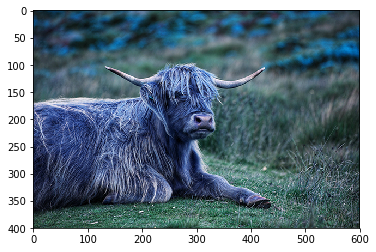

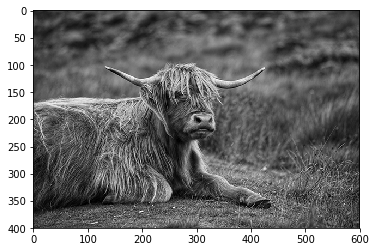

In [121]:
plt.imshow(imcolor)
plt.figure()
plt.imshow(imbw, cmap="gray")

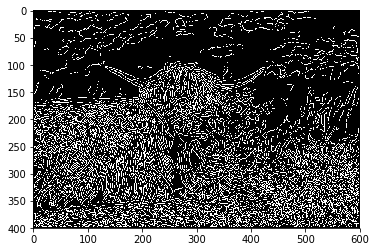

In [122]:
edges = feature.canny(
    image=imbw,
    sigma=1.,
)
plt.imshow(edges, cmap='gray')
edges_im = Image.fromarray(edges.astype(np.int32) * 255)
edges_im = edges_im.convert('RGB')
edges_im.save("edges.png")

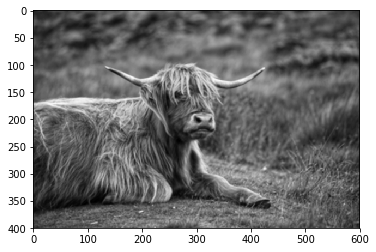

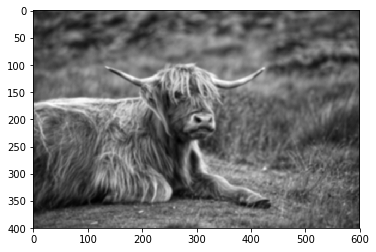

In [123]:
w1 = (2 * math.ceil(2 * std1)) + 1
im1 = cv2.GaussianBlur(imbw, (w1, w1), std1)

w2 = (2 * math.ceil(2 * std2)) + 1
im2 = cv2.GaussianBlur(imbw, (w2, w2), std2)

plt.imshow(im1,cmap='gray')
plt.figure()
plt.imshow(im2,cmap='gray')

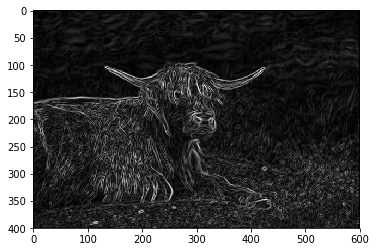

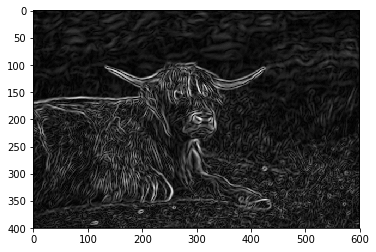

In [124]:
sobelx1 = cv2.Sobel(im1, cv2.CV_64F, 1, 0, ksize=1)
sobely1 = cv2.Sobel(im1, cv2.CV_64F, 0, 1, ksize=1)
grad1 = np.sqrt(sobelx1**2 + sobely1**2)

sobelx2 = cv2.Sobel(im2, cv2.CV_64F, 1, 0, ksize=1)
sobely2 = cv2.Sobel(im2, cv2.CV_64F, 0, 1, ksize=1)
grad2 = np.sqrt(sobelx2**2 + sobely2**2)

plt.imshow(grad1, cmap='gray')
plt.figure()
plt.imshow(grad2, cmap='gray')

/Users/isthisangela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/isthisangela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


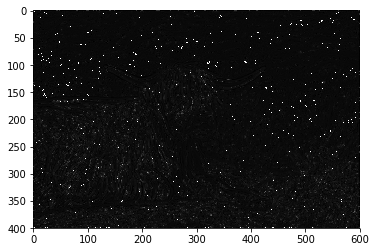

In [125]:
diff = np.abs(grad1 / grad2)
plt.imshow(diff, cmap='gray')
diff_im = Image.fromarray(diff * 255)
diff_im = diff_im.convert('RGB')
diff_im.save("diff.png")

/Users/isthisangela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/isthisangela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/isthisangela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


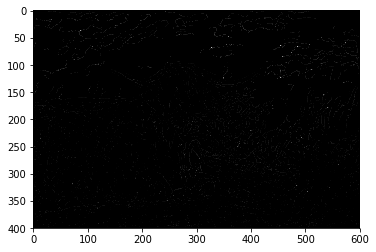

In [126]:
sig = np.sqrt((diff**2 * std1**2 - std2**2) / (1. - diff**2))
sparse = sig * (1 * edges)
sparse[np.isnan(sparse)] = 0

plt.imshow(sparse * 255, cmap='gray')
sparse_im = Image.fromarray(sparse * 100)
sparse_im = sparse_im.convert('RGB')
sparse_im.save("sparse.png")

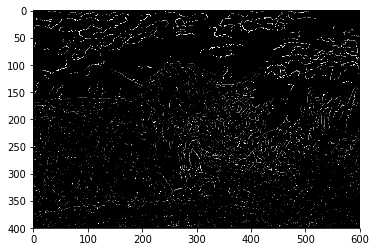

In [127]:
sparse_denoised = sparse.copy()
if denoise:
    sparse_denoised[sparse > maxBlur] = maxBlur

plt.imshow(sparse_denoised, cmap='gray')
sparse_denoised_im = Image.fromarray(sparse_denoised * 100)
sparse_denoised_im = sparse_denoised_im.convert('RGB')
sparse_denoised_im.save("sparse_denoised.png")

In [128]:
normed = (imcolor.astype(float) / np.linalg.norm(imcolor.astype(float)))
L = cf_laplacian(normed, epsilon=1e-11, radius=1)
D = scipy.sparse.diags(edges.flatten(), dtype=np.int8)

In [129]:
A = scipy.sparse.csc_matrix(L + lamb * D)
b = scipy.sparse.csc_matrix(lamb * D * sparse_denoised.flatten()).T

In [130]:
x = scipy.sparse.linalg.spsolve(A, b)[:, np.newaxis]

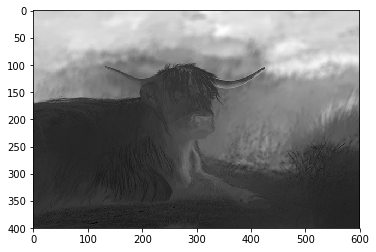

In [134]:
full = x.reshape(sparse.shape)
plt.imshow(full, cmap='gray')
full_im = Image.fromarray(full * 100)
full_im = full_im.convert('RGB')
full_im.save("full.png")
np.save('full.npy', full)